# Final Project: Training Process

In [ ]:
%matplotlib notebook
import numpy as np
import torch
import torch.optim as optim
from tqdm import tqdm
import matplotlib.image as image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from Unet import UNet                             # The Neural Network (by Colby Wang)
from loss_function import MonocularDepthLoss      # Loss Function      (by Suyeong Choi)
from dataloader import CustomDataset              # Custom Dataloader  (by Suyeong Choi)

# Path Variables
DATASET_PATH = 'dataset'
LEFT = 'image_L'
RIGHT = 'image_R'
DISPARITY = 'disparity'

# Define device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Helper Functions for Cropping image and Tensor permutation (by Alex Wang)
def image_transform_single(img, height, width):
    
    # Make sure all the image sample has same size defined by (height, width) by cutting the image or filling 0s
    result = np.zeros((height, width, 3), dtype=np.float32)
    img_height = img.shape[0]
    img_width = img.shape[1]
    min_height = min(img_height, height)
    min_width = min(img_width, width)
    result[:min_height, :min_width,:] = img[:min_height, :min_width,:]
    
    # The returned value should have 3 matrices for each channel
    return np.array([result[:,:,0], result[:,:,1], result[:,:,2]])

def disparity_transform(disparity, height, width):
    result = np.zeros((height, width), dtype=np.float32)
    d_height = disparity.shape[0]
    d_width = disparity.shape[1]
    min_height = min(d_height, height)
    min_width = min(d_width, width)
    result[:min_height, :min_width] = disparity[:min_height, :min_width]
    return result

def image_transform(sample):
    result_sample = {LEFT: image_transform_single(sample[LEFT], HEIGHT, WIDTH)}
    if sample[RIGHT] is not None:
        result_sample[RIGHT] = image_transform_single(sample[RIGHT], HEIGHT, WIDTH)
        result_sample[DISPARITY] = disparity_transform(sample[DISPARITY], HEIGHT, WIDTH)
    return result_sample

## Demo for batch training

Training Epochs:   0%|          | 0/2000 [00:00<?, ?it/s]/h/ziyuwang/.conda/envs/myenv/lib/python3.9/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
Training Epochs: 100%|██████████| 2000/2000 [12:09:52<00:00, 21.90s/it]  


<IPython.core.display.Javascript object>


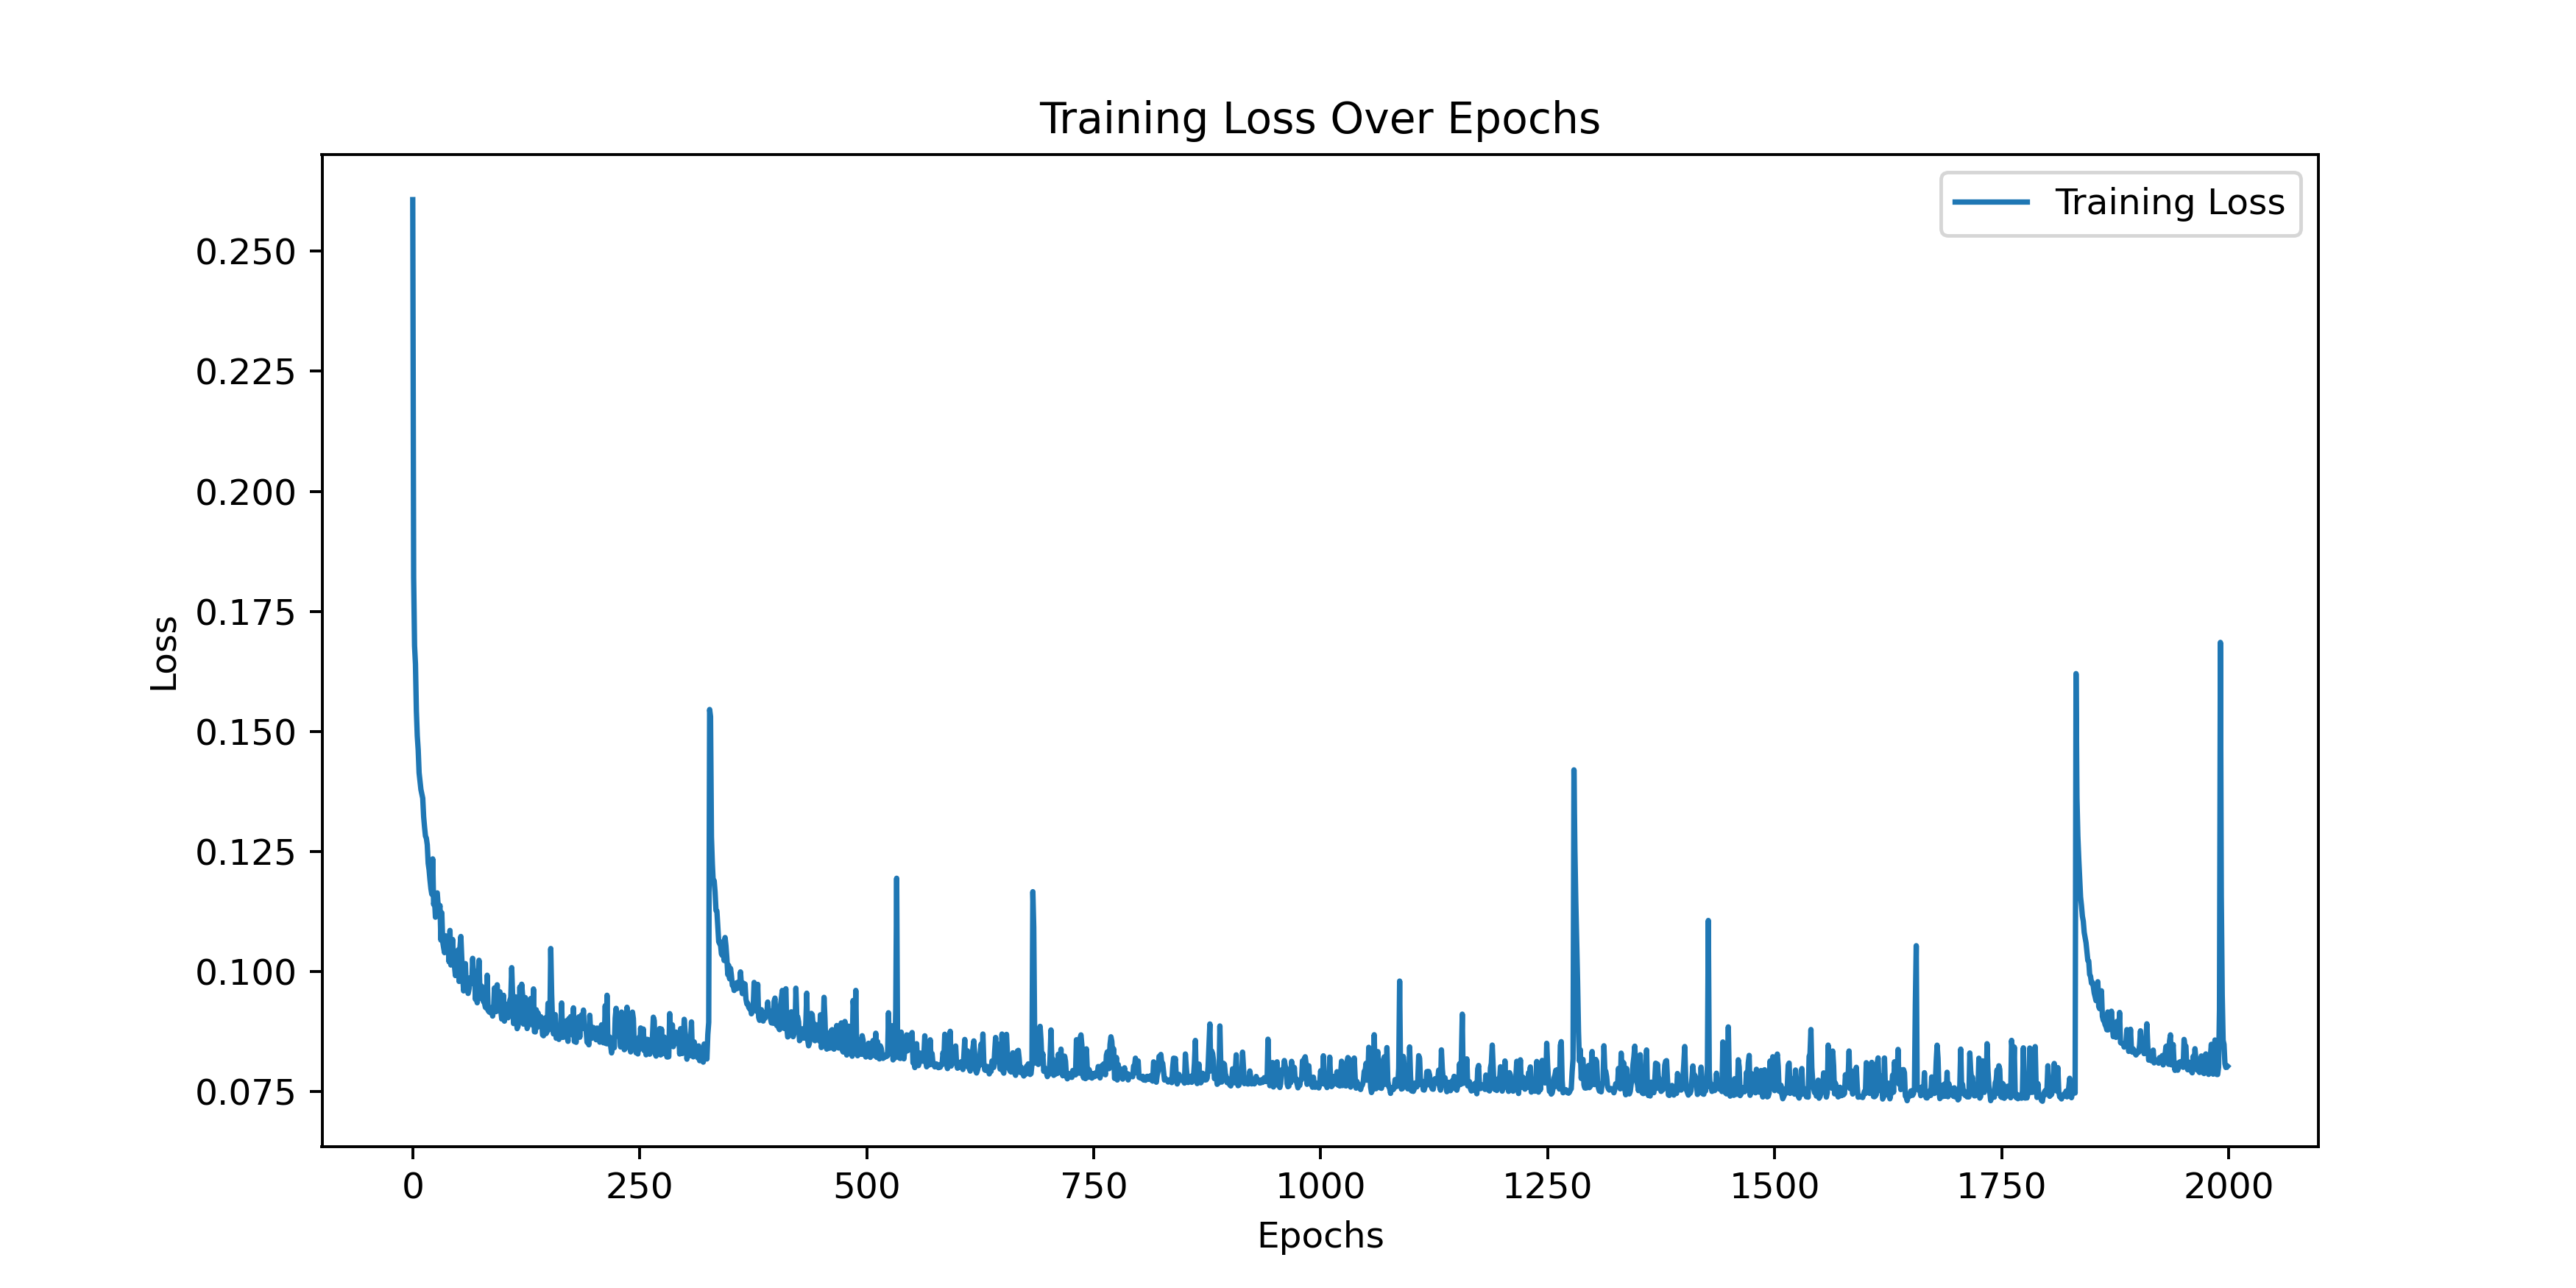

In [3]:
# Initialize DataLoader
training_dataset = CustomDataset(root_dir=DATASET_PATH, transform=image_transform)
train_loader = DataLoader(training_dataset, batch_size=5, shuffle=True)  # Set a valid batch size

# Initialize the U-Net model and loss function
model = UNet()
loss_function = MonocularDepthLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs to train (set high to see if it can overfit)
epochs = 2000

# List to record losses
loss_history = []

# Training Loop
model.to(device)
model.train() # Set model to training mode

for epoch in tqdm(range(epochs), desc="Training Epochs"):
    epoch_loss = 0.0
    for i, sample in enumerate(train_loader):
        # print(i)
        image_l = (sample[LEFT].float() / 255.0).to(device)
        image_r = (sample[RIGHT].float() / 255.0).to(device)
        
        optimizer.zero_grad()

        # Forward pass
        right_disparity, left_disparity = model(image_l)

        # Calculate loss
        loss, left_image, right_image = loss_function(left_disparity, image_l, image_r, right_disparity)
        epoch_loss += loss.item()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
    epoch_loss /= len(train_loader)
    loss_history.append(epoch_loss)


plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Save the plot to a PNG file
plt.savefig('training_loss.png') 

plt.show()

In [6]:
model_path = 'model.pth'

# # Save the model state dictionary
torch.save(model.state_dict(), model_path)